Using Full features of Dataset A

Importing all the libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.linear_model import LogisticRegression
import mord as m
from tabulate import tabulate
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
df = pd.read_csv("/content/emp2.csv")

df.head()

,Employee_ID,Department,Gender,Age,Job_Title,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
0,1,IT,Male,55,Specialist,2022-01-19 08:03:05.556036,2,High School,5,6750.0,33,32,22,2,0,14,66,0,2.63,False
1,2,Finance,Male,29,Developer,2024-04-18 08:03:05.556036,0,High School,5,7500.0,34,34,13,14,100,12,61,2,1.72,False
2,3,Finance,Male,55,Specialist,2015-10-26 08:03:05.556036,8,High School,3,5850.0,37,27,6,3,50,10,1,0,3.17,False
3,4,Customer Support,Female,48,Analyst,2016-10-22 08:03:05.556036,7,Bachelor,2,4800.0,52,10,28,12,100,10,0,1,1.86,False
4,5,Engineering,Female,36,Analyst,2021-07-23 08:03:05.556036,3,Bachelor,2,4800.0,38,11,29,13,100,15,9,1,1.25,False


In [ ]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Employee_ID                  100000 non-null  int64  
 1   Department                   100000 non-null  object 
 2   Gender                       100000 non-null  object 
 3   Age                          100000 non-null  int64  
 4   Job_Title                    100000 non-null  object 
 5   Hire_Date                    100000 non-null  object 
 6   Years_At_Company             100000 non-null  int64  
 7   Education_Level              100000 non-null  object 
 8   Performance_Score            100000 non-null  int64  
 9   Monthly_Salary               100000 non-null  float64
 10  Work_Hours_Per_Week          100000 non-null  int64  
 11  Projects_Handled             100000 non-null  int64  
 12  Overtime_Hours               100000 non-null  int64  
 13  

In [ ]:
# Safely convert Hire_Date to datetime format, coercing any malformed entries to NaT
df['Hire_Date'] = pd.to_datetime(df['Hire_Date'], errors='coerce')

# Extracting hire year and compute tenure
df['Hire_Year'] = df['Hire_Date'].dt.year
df['Tenure'] = 2025 - df['Hire_Year']

# Selecting columns relevant to predicting performance (excluding 'Resigned')
selected_columns = [
    'Performance_Score',

    # Work-life balance indicators
    'Work_Hours_Per_Week', 'Overtime_Hours', 'Remote_Work_Frequency', 'Sick_Days',
    'Projects_Handled', 'Employee_Satisfaction_Score',

    # Control variables
    'Gender', 'Age', 'Department', 'Education_Level', 'Years_At_Company',
    'Monthly_Salary', 'Promotions', 'Training_Hours', 'Team_Size', 'Tenure'
]

# Filtering the dataframe to only the selected columns
df = df[selected_columns]

df.head()


,Performance_Score,Work_Hours_Per_Week,Overtime_Hours,Remote_Work_Frequency,Sick_Days,Projects_Handled,Employee_Satisfaction_Score,Gender,Age,Department,Education_Level,Years_At_Company,Monthly_Salary,Promotions,Training_Hours,Team_Size,Tenure
0,5,33,22,0,2,32,2.63,Male,55,IT,High School,2,6750.0,0,66,14,3
1,5,34,13,100,14,34,1.72,Male,29,Finance,High School,0,7500.0,2,61,12,1
2,3,37,6,50,3,27,3.17,Male,55,Finance,High School,8,5850.0,0,1,10,10
3,2,52,28,100,12,10,1.86,Female,48,Customer Support,Bachelor,7,4800.0,1,0,10,9
4,2,38,29,100,13,11,1.25,Female,36,Engineering,Bachelor,3,4800.0,1,9,15,4


Encoding Categorical Variables using One Hot Encoding(creates binary columns for each category)

Gender has ['Male', 'Female', 'Other']: |
we’ll get two columns: Gender_Male, Gender_Other  |
Gender_Female is dropped (becomes baseline)  |
Same with Department and Education_Level

In [ ]:
categorical_cols = ['Gender', 'Department', 'Education_Level']

# One-hot encode to avoid dummy variable trap
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_encoded.head()


,Performance_Score,Work_Hours_Per_Week,Overtime_Hours,Remote_Work_Frequency,Sick_Days,Projects_Handled,Employee_Satisfaction_Score,Age,Years_At_Company,Monthly_Salary,...,Department_Finance,Department_HR,Department_IT,Department_Legal,Department_Marketing,Department_Operations,Department_Sales,Education_Level_High School,Education_Level_Master,Education_Level_PhD
0,5,33,22,0,2,32,2.63,55,2,6750.0,...,False,False,True,False,False,False,False,True,False,False
1,5,34,13,100,14,34,1.72,29,0,7500.0,...,True,False,False,False,False,False,False,True,False,False
2,3,37,6,50,3,27,3.17,55,8,5850.0,...,True,False,False,False,False,False,False,True,False,False
3,2,52,28,100,12,10,1.86,48,7,4800.0,...,False,False,False,False,False,False,False,False,False,False
4,2,38,29,100,13,11,1.25,36,3,4800.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Using all features except the target
X_full = df_encoded.drop('Performance_Score', axis=1)
y_full = df_encoded['Performance_Score']

In [ ]:
y_full_xgb = y_full - 1  # only needed for XGB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

In [ ]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

XGBoost Model

XGBoost (Full Features)

              precision    recall  f1-score   support

           1       0.88      0.98      0.93      4024
           2       0.89      0.80      0.84      4003
           3       1.00      1.00      1.00      4000
           4       1.00      1.00      1.00      3988
           5       0.93      0.92      0.93      3985

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Accuracy: 0.9396


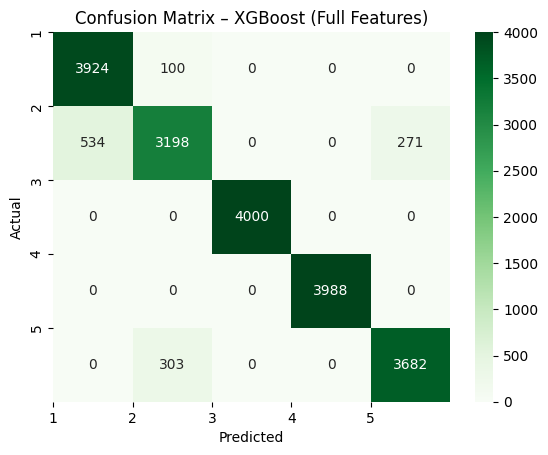

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Defining features and target variable
# Dropping the target column to create feature set
X_full = df_encoded.drop('Performance_Score', axis=1)
# Extract target variable
y_full = df_encoded['Performance_Score']
# Adjust labels for XGBoost (requires 0-based indexing for classification)
y_full_xgb = y_full - 1

# Split data into training and testing sets
# Use stratified split to maintain class distribution
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full_xgb, test_size=0.2, stratify=y_full_xgb, random_state=42
)

# Handle class imbalance using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Scale features for better model performance
# Standardize features to have mean=0 and variance=1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit scaler on training data and transform
X_train_scaled = scaler.fit_transform(X_train_smote)
# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Initializing and training XGBoost model with default parameters for reproducibility
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train_smote)

# Making predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Converting predictions and true labels back to original scale (1–5)
y_pred_actual = y_pred_xgb + 1
y_test_actual = y_test + 1

# Evaluate model performance
print("XGBoost (Full Features)\n")
print(classification_report(y_test_actual, y_pred_actual))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

# Visualize confusion matrix
# Use heatmap for clear representation of model performance
sns.heatmap(
    confusion_matrix(y_test_actual, y_pred_actual),
    annot=True,
    fmt='d',
    cmap='Greens'
)
plt.title("Confusion Matrix – XGBoost (Full Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# Set ticks to reflect original label scale (1–5)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
plt.show()

Random Forest Model

Random Forest (Full Features)

              precision    recall  f1-score   support

           1       0.49      0.86      0.62      4024
           2       0.69      0.63      0.66      4003
           3       0.80      0.70      0.75      4000
           4       0.92      0.66      0.77      3988
           5       0.98      0.72      0.83      3985

    accuracy                           0.72     20000
   macro avg       0.78      0.71      0.73     20000
weighted avg       0.78      0.72      0.73     20000

Accuracy: 0.71505


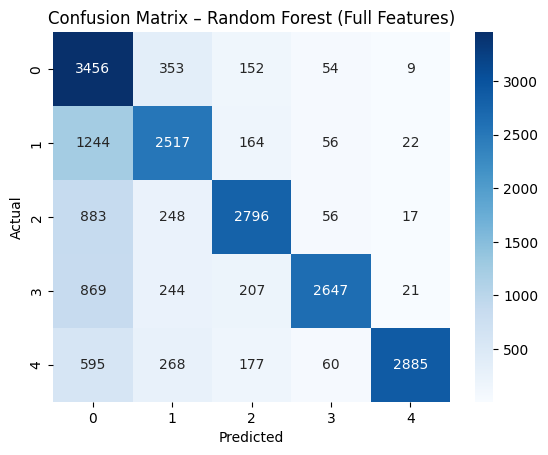

In [ ]:
# Dropping the target column to create feature set
X_full = df_encoded.drop('Performance_Score', axis=1)
# Extracting target variable
y_full = df_encoded['Performance_Score']

# Split data into training and testing sets
# Use stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Scaling features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Training Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_smote)

# Prediction on test set
y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest (Full Features)\n")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest (Full Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Linear Regression Model

Linear Regression (Full Features – Rounded Output)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4024
           2       0.29      0.41      0.34      4003
           3       0.19      0.43      0.26      4000
           4       0.33      0.42      0.37      3988
           5       0.00      0.00      0.00      3985

    accuracy                           0.25     20000
   macro avg       0.16      0.25      0.19     20000
weighted avg       0.16      0.25      0.19     20000

Accuracy: 0.2528


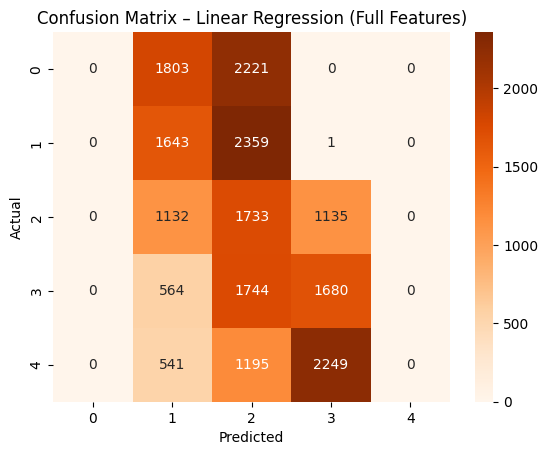

In [ ]:
X_full = df_encoded.drop('Performance_Score', axis=1)
y_full = df_encoded['Performance_Score']

# Split data into training and testing sets
# Use stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Scaling features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Training Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_smote)

# Prediction of continuous values on test set
y_pred_lr_continuous = lr_model.predict(X_test_scaled)

# Rounded to nearest integer (and to 1–5)
y_pred_lr = np.clip(np.round(y_pred_lr_continuous), 1, 5).astype(int)

# Evaluation
print("Linear Regression (Full Features – Rounded Output)\n")
print(classification_report(y_test, y_pred_lr, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix – Linear Regression (Full Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Logistic Regression Model

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression (Full Features)

              precision    recall  f1-score   support

           1       0.34      0.55      0.42      4024
           2       0.20      0.11      0.14      4003
           3       0.18      0.12      0.14      4000
           4       0.19      0.12      0.15      3988
           5       0.37      0.56      0.45      3985

    accuracy                           0.29     20000
   macro avg       0.26      0.29      0.26     20000
weighted avg       0.26      0.29      0.26     20000

Accuracy: 0.2928


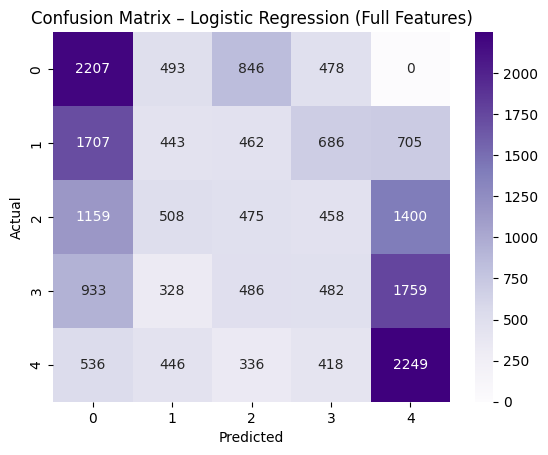

In [ ]:
X_full = df_encoded.drop('Performance_Score', axis=1)
y_full = df_encoded['Performance_Score']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Scaling features for performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Training Multinomial Logistic Regression model
log_model = LogisticRegression(
    multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42
)
log_model.fit(X_train_scaled, y_train_smote)

# Predicting using trained logistic regression model
y_pred_log = log_model.predict(X_test_scaled)

# Evaluation
print("Logistic Regression (Full Features)\n")
print(classification_report(y_test, y_pred_log, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix – Logistic Regression (Full Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
pip install mord

Ordinal Regression Model

Ordinal Logistic Regression (Full Features)

              precision    recall  f1-score   support

           1       0.61      0.13      0.22      4024
           2       0.23      0.35      0.28      4003
           3       0.18      0.29      0.23      4000
           4       0.31      0.45      0.36      3988
           5       1.00      0.28      0.44      3985

    accuracy                           0.30     20000
   macro avg       0.47      0.30      0.31     20000
weighted avg       0.47      0.30      0.31     20000

Accuracy: 0.2991


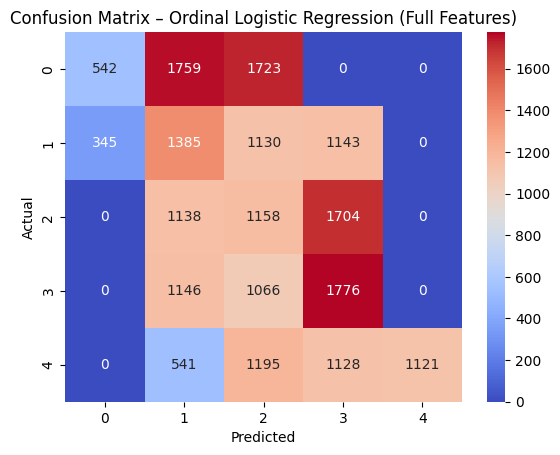

In [ ]:
X_full = df_encoded.drop('Performance_Score', axis=1)
y_full = df_encoded['Performance_Score']

# Splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Train Ordinal Logistic Regression
ordinal_model = m.LogisticAT(alpha=1.0)
ordinal_model.fit(X_train_scaled, y_train_smote)

# Predictnig using ordinal regression model
y_pred_ordinal = ordinal_model.predict(X_test_scaled)

# Evaluation
print("Ordinal Logistic Regression (Full Features)\n")
print(classification_report(y_test, y_pred_ordinal, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_ordinal))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_ordinal), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix – Ordinal Logistic Regression (Full Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Full feature test labels
y_test_full = y_test

# full features only
models_full = {
    "Linear Regression (Full)": y_pred_lr,
    "Logistic Regression (Full)": y_pred_log,
    "Ordinal Regression (Full)": y_pred_ordinal,
    "Random Forest (Full)": y_pred_rf,
    "XGBoost (Full)": y_pred_actual
}

# Collecting model metrics
results_full = []
for model_name, y_pred in models_full.items():
    precision = precision_score(y_test_full, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test_full, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_full, y_pred, average='macro', zero_division=0)
    accuracy = accuracy_score(y_test_full, y_pred)
    results_full.append([model_name, precision, recall, f1, accuracy])

# Created a DataFrame
df_metrics_full = pd.DataFrame(results_full, columns=["Models", "Precision", "Recall", "F1-Score", "Accuracy"])

# Added an average row
average_row_full = df_metrics_full.iloc[:, 1:].mean().to_list()
df_metrics_full.loc[len(df_metrics_full.index)] = ["Average"] + average_row_full

# Rounded up values
df_metrics_full.iloc[:, 1:] = df_metrics_full.iloc[:, 1:].round(2)

print(tabulate(df_metrics_full, headers='keys', tablefmt='fancy_grid', showindex=False))


╒════════════════════════════╤═════════════╤══════════╤════════════╤════════════╕
│ Models                     │   Precision │   Recall │   F1-Score │   Accuracy │
╞════════════════════════════╪═════════════╪══════════╪════════════╪════════════╡
│ Linear Regression (Full)   │        0.16 │     0.25 │       0.19 │       0.25 │
├────────────────────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Logistic Regression (Full) │        0.26 │     0.29 │       0.26 │       0.29 │
├────────────────────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Ordinal Regression (Full)  │        0.47 │     0.3  │       0.31 │       0.3  │
├────────────────────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Random Forest (Full)       │        0.78 │     0.71 │       0.73 │       0.72 │
├────────────────────────────┼─────────────┼──────────┼────────────┼────────────┤
│ XGBoost (Full)             │        0.94 │     0.94 │       0.94 │       0.94 │
├───────────────

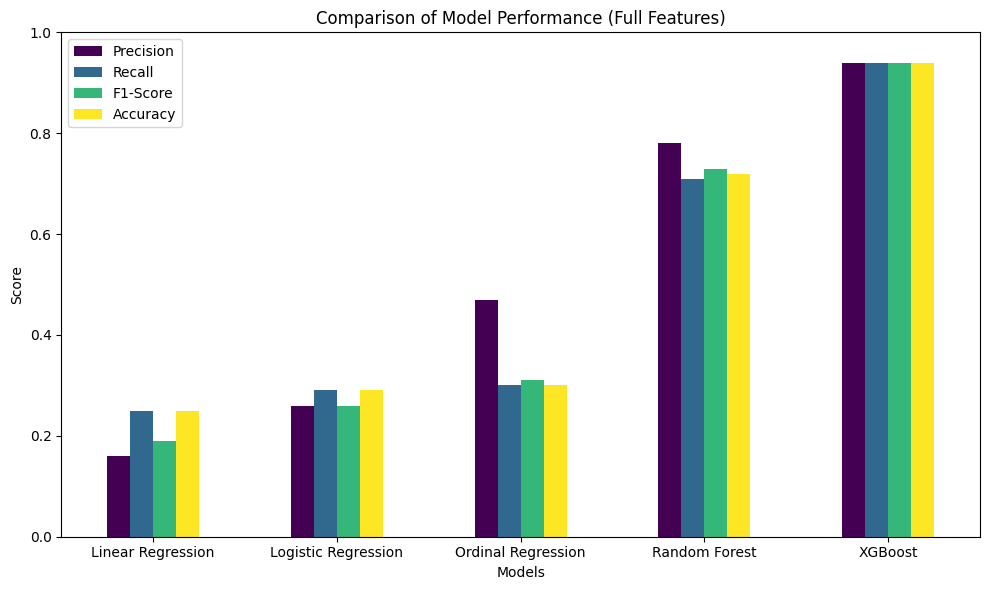

In [ ]:
import matplotlib.pyplot as plt

# Using the already computed df_metrics_full and removing 'Average' row if present
df_plot = df_metrics_full[df_metrics_full["Models"] != "Average"].copy()

# Cleaned up model names for display
df_plot["Models"] = df_plot["Models"].str.replace(" \(Full\)", "", regex=True)
df_plot.set_index("Models", inplace=True)

# Plot bar chart
df_plot[["Precision", "Recall", "F1-Score", "Accuracy"]].plot(
    kind='bar', figsize=(10, 6), colormap='viridis'
)
plt.title("Comparison of Model Performance (Full Features)")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

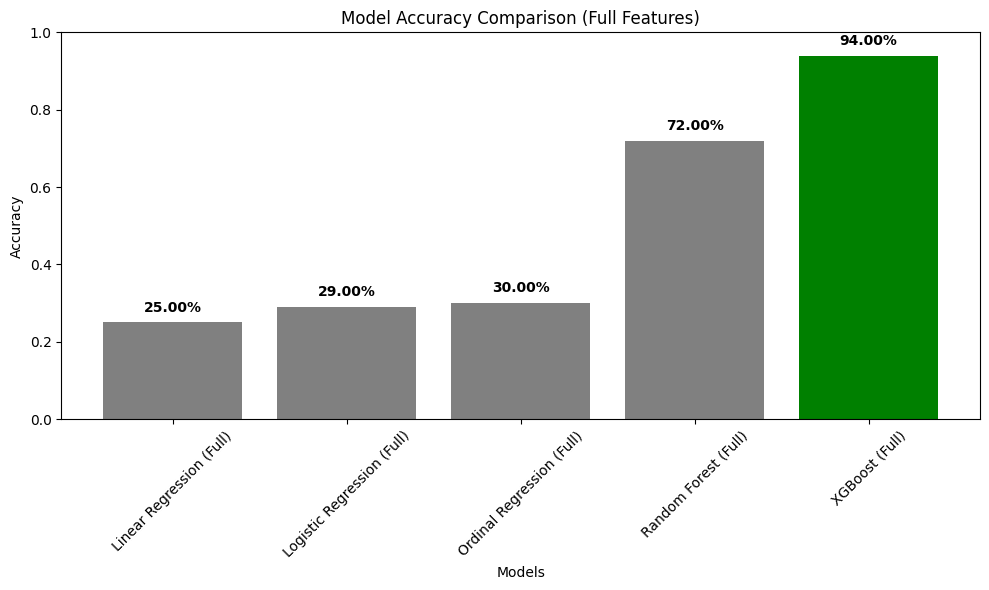

In [ ]:
# Filtering out the "Average" row if present
df_plot = df_metrics_full[df_metrics_full["Models"] != "Average"]

# Plotting bar chart for Accuracy
colors = ['green' if model == "XGBoost (Full)" else 'gray' for model in df_plot["Models"]]

plt.figure(figsize=(10, 6))
bars = plt.bar(df_plot["Models"], df_plot["Accuracy"], color=colors)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Full Features)")
plt.ylim(0, 1)  # since accuracy ranges from 0 to 1
plt.xticks(rotation=45)
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the accuracy values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (accuracy)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval*100:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm

#Using encoded data
X = df_encoded.drop('Performance_Score', axis=1)
y = df_encoded['Performance_Score']

#Added intercept
X_sm = sm.add_constant(X)

#Ensuring all data is numeric
X_sm = X_sm.astype(float)
y = y.astype(int)

#Fit the model
model = sm.MNLogit(y, X_sm)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 1.461666
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:      Performance_Score   No. Observations:               100000
Model:                        MNLogit   Df Residuals:                    99892
Method:                           MLE   Df Model:                          104
Date:                Mon, 14 Apr 2025   Pseudo R-squ.:                 0.09181
Time:                        18:05:12   Log-Likelihood:            -1.4617e+05
converged:                       True   LL-Null:                   -1.6094e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
        Performance_Score=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -2.0988      0.106    -19.831      0.000   

<ipython-input-109-0f0e3eeb872f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


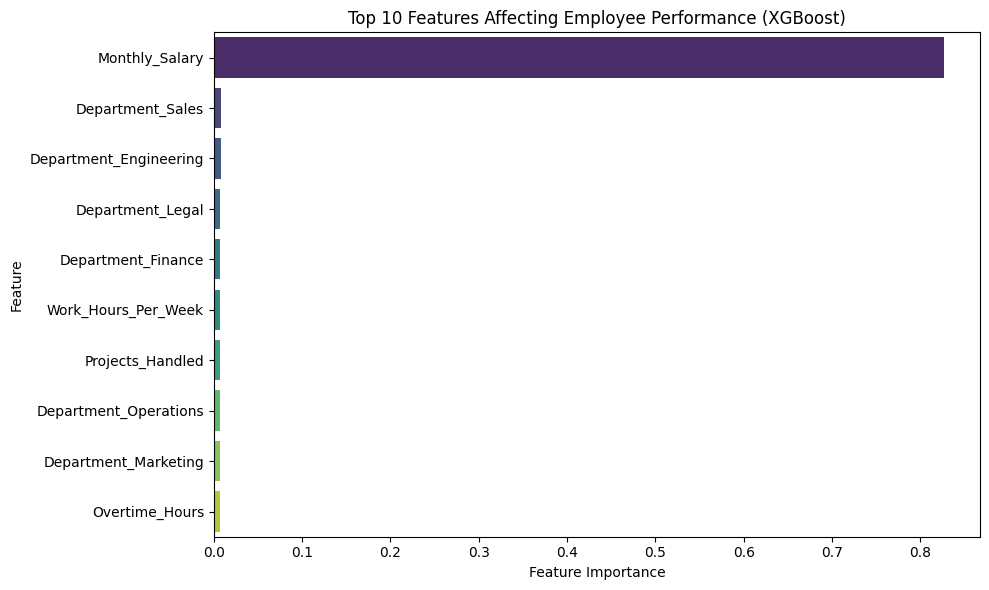

In [ ]:
# Getting feature importances from trained XGBoost model
feature_importances = xgb_model.feature_importances_

# DataFrame with feature names and their importances
importance_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': feature_importances
})

# Sort by importance (descending) and select top 10
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Features Affecting Employee Performance (XGBoost)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Using only WLB Features of Dataset A

Encoding Categorical Variables using One Hot Encoding(creates binary columns for each category)

Gender has ['Male', 'Female', 'Other']: |
we’ll get two columns: Gender_Male, Gender_Other  |
Gender_Female is dropped (becomes baseline)  |
Same with Department and Education_Level

In [ ]:
categorical_cols = ['Gender', 'Department', 'Education_Level']

# One-hot encode to avoid dummy variable trap
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_encoded.head()


,Performance_Score,Work_Hours_Per_Week,Overtime_Hours,Remote_Work_Frequency,Sick_Days,Projects_Handled,Employee_Satisfaction_Score,Age,Years_At_Company,Monthly_Salary,...,Department_Finance,Department_HR,Department_IT,Department_Legal,Department_Marketing,Department_Operations,Department_Sales,Education_Level_High School,Education_Level_Master,Education_Level_PhD
0,5,33,22,0,2,32,2.63,55,2,6750.0,...,False,False,True,False,False,False,False,True,False,False
1,5,34,13,100,14,34,1.72,29,0,7500.0,...,True,False,False,False,False,False,False,True,False,False
2,3,37,6,50,3,27,3.17,55,8,5850.0,...,True,False,False,False,False,False,False,True,False,False
3,2,52,28,100,12,10,1.86,48,7,4800.0,...,False,False,False,False,False,False,False,False,False,False
4,2,38,29,100,13,11,1.25,36,3,4800.0,...,False,False,False,False,False,False,False,False,False,False


WE WILL BE USING 2 MODELS
1. X=WLB-only features that predicts the performance based on these said features
2. X=all features so that we can compare WLB feature with non-WLB to see how much WLB features have an impact on performance

1. WLB features andd Targets

In [ ]:
# Defining WLB features only
wlb_features = [
    'Work_Hours_Per_Week', 'Projects_Handled', 'Overtime_Hours',
    'Sick_Days', 'Remote_Work_Frequency', 'Employee_Satisfaction_Score'
]

# Input (X) and Target (y)
X = df_encoded[wlb_features]
y = df_encoded['Performance_Score']-1

^^^Xgboost class labels starts from '0' [0,1,2,3,4] but our performance values start from '1' [1,2,3,4,5] . So the y variable has '-1' so that it starts from '0'. We will change this after completing XGBoost model as it will affect other models.

checking class distribution

In [ ]:
# Checking if classes are balanced
y.value_counts().sort_index()


,count
Performance_Score,
0,20120
1,20013
2,19999
3,19940
4,19928


VIF analysis

In [ ]:
# Scaling WLB features before VIF
X_vif_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Computing VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif_scaled.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_scaled.values, i) for i in range(X_vif_scaled.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))


                       Feature       VIF
1             Projects_Handled  1.000097
2               Overtime_Hours  1.000089
0          Work_Hours_Per_Week  1.000073
3                    Sick_Days  1.000045
4        Remote_Work_Frequency  1.000042
5  Employee_Satisfaction_Score  1.000042


^^ VIF is under 5 so no multi-colinearilality

Training-Testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Applying SMOTE on Training set only

In [ ]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)


Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)


XGBoost model

In [ ]:
model = XGBClassifier(random_state=42)
model.fit(X_train_scaled, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#Prediction on test set
y_pred_xgb = model.predict(X_test_scaled)


shifting to the original label ( '0' -> '1' )

In [ ]:
y_pred_actual = y_pred_xgb + 1
y_test_actual = y_test + 1

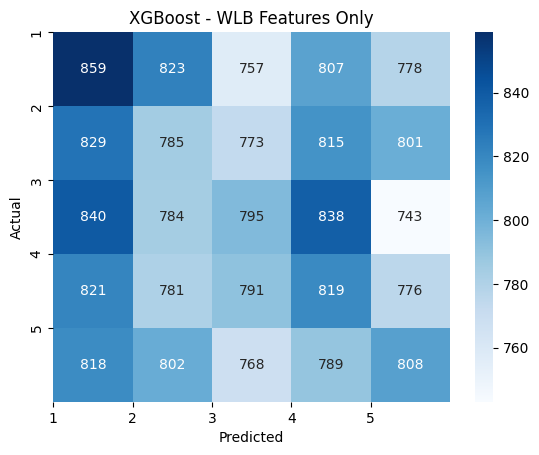

              precision    recall  f1-score   support

           1       0.21      0.21      0.21      4024
           2       0.20      0.20      0.20      4003
           3       0.20      0.20      0.20      4000
           4       0.20      0.21      0.20      3988
           5       0.21      0.20      0.20      3985

    accuracy                           0.20     20000
   macro avg       0.20      0.20      0.20     20000
weighted avg       0.20      0.20      0.20     20000

Accuracy: 0.2033


In [ ]:
#Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost - WLB Features Only')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])

plt.show()

# Classification Report
print(classification_report(y_test_actual, y_pred_actual))

# Accuracy
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))


^^^
Predictions are evenly spread across all classes.

Most predictions are wrong or off by 1–2 points.

Very weak diagonal trend → Model can't distinguish between performance levels using WLB alone.

Random Forest

In [ ]:
# Initializing the Random Forest classifier with a fixed random state
rf_model = RandomForestClassifier(random_state=42)

# Training the Random Forest model using the scaled training data and the SMOTE-resampled target variable
rf_model.fit(X_train_scaled, y_train_smote)
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Random Forest (WLB Only)\n")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest (WLB Only)

[[802 833 783 831 775]
 [868 773 825 823 714]
 [881 849 785 712 773]
 [816 859 813 770 730]
 [848 833 765 795 744]]
              precision    recall  f1-score   support

           0       0.19      0.20      0.19      4024
           1       0.19      0.19      0.19      4003
           2       0.20      0.20      0.20      4000
           3       0.20      0.19      0.19      3988
           4       0.20      0.19      0.19      3985

    accuracy                           0.19     20000
   macro avg       0.19      0.19      0.19     20000
weighted avg       0.19      0.19      0.19     20000

Accuracy: 0.1937


Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_smote)
y_pred_lr_raw = lr_model.predict(X_test_scaled)

# Round to nearest class (1–5)
y_pred_lr = np.clip(np.round(y_pred_lr_raw), 1, 5).astype(int)

print("Linear Regression (WLB Only - Rounded Output)\n")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


Linear Regression (WLB Only - Rounded Output)

[[   0    0 4024    0    0]
 [   0    0 4003    0    0]
 [   0    0 4000    0    0]
 [   0    0 3988    0    0]
 [   0    0 3985    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4024
           1       0.00      0.00      0.00      4003
           2       0.20      1.00      0.33      4000
           3       0.00      0.00      0.00      3988
           4       0.00      0.00      0.00      3985

    accuracy                           0.20     20000
   macro avg       0.04      0.20      0.07     20000
weighted avg       0.04      0.20      0.07     20000

Accuracy: 0.2


Logistic Regression

In [ ]:
log_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_model.fit(X_train_scaled, y_train_smote)
y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression (WLB Only)\n")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))


Logistic Regression (WLB Only)

[[ 997  361 1156  856  654]
 [ 995  351 1122  861  674]
 [ 954  358 1163  820  705]
 [ 991  331 1194  843  629]
 [1026  326 1131  828  674]]
              precision    recall  f1-score   support

           0       0.20      0.25      0.22      4024
           1       0.20      0.09      0.12      4003
           2       0.20      0.29      0.24      4000
           3       0.20      0.21      0.21      3988
           4       0.20      0.17      0.18      3985

    accuracy                           0.20     20000
   macro avg       0.20      0.20      0.19     20000
weighted avg       0.20      0.20      0.19     20000

Accuracy: 0.2014


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Oridnal Regression

In [ ]:
pip install mord

In [ ]:
ordinal_model = m.LogisticAT(alpha=1.0)  # 'AT' = All-threshold version
ordinal_model.fit(X_train_scaled, y_train_smote)
y_pred_ordinal = ordinal_model.predict(X_test_scaled)

print("Ordinal Logistic Regression (WLB Only)\n")
print(confusion_matrix(y_test, y_pred_ordinal))
print(classification_report(y_test, y_pred_ordinal, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_ordinal))


Ordinal Logistic Regression (WLB Only)

[[   0    0 4024    0    0]
 [   0    0 4003    0    0]
 [   0    0 4000    0    0]
 [   0    0 3988    0    0]
 [   0    0 3985    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4024
           1       0.00      0.00      0.00      4003
           2       0.20      1.00      0.33      4000
           3       0.00      0.00      0.00      3988
           4       0.00      0.00      0.00      3985

    accuracy                           0.20     20000
   macro avg       0.04      0.20      0.07     20000
weighted avg       0.04      0.20      0.07     20000

Accuracy: 0.2


^^^WLB-only features are weak indicators of performance

Comparison of the models

In [ ]:
# Fixed the label range
y_test_wlb = y_test + 1

models = {
    "Linear Regression": y_pred_lr,
    "Logistic Regression": y_pred_log,
    "Ordinal Regression": y_pred_ordinal,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_actual
}

# Collecting model metrics
results = []
for model_name, y_pred in models.items():
    precision = precision_score(y_test_wlb, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test_wlb, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_wlb, y_pred, average='macro', zero_division=0)
    accuracy = accuracy_score(y_test_wlb, y_pred)
    results.append([model_name, precision, recall, f1, accuracy])

# Created a DataFrame
df_metrics = pd.DataFrame(results, columns=["Models", "Precision", "Recall", "f-Score", "Accuracy"])

# Added average row
average_row = df_metrics.iloc[:, 1:].mean().to_list()
df_metrics.loc[len(df_metrics.index)] = ["Average"] + average_row

# Rounded up values
df_metrics.iloc[:, 1:] = df_metrics.iloc[:, 1:].round(2)

print(tabulate(df_metrics, headers='keys', tablefmt='fancy_grid', showindex=False))


╒═════════════════════╤═════════════╤══════════╤═══════════╤════════════╕
│ Models              │   Precision │   Recall │   f-Score │   Accuracy │
╞═════════════════════╪═════════════╪══════════╪═══════════╪════════════╡
│ Linear Regression   │        0.04 │     0.2  │      0.07 │       0.2  │
├─────────────────────┼─────────────┼──────────┼───────────┼────────────┤
│ Logistic Regression │        0.13 │     0.12 │      0.12 │       0.15 │
├─────────────────────┼─────────────┼──────────┼───────────┼────────────┤
│ Ordinal Regression  │        0.04 │     0.2  │      0.07 │       0.2  │
├─────────────────────┼─────────────┼──────────┼───────────┼────────────┤
│ Random Forest       │        0.13 │     0.13 │      0.13 │       0.16 │
├─────────────────────┼─────────────┼──────────┼───────────┼────────────┤
│ XGBoost             │        0.2  │     0.2  │      0.2  │       0.2  │
├─────────────────────┼─────────────┼──────────┼───────────┼────────────┤
│ Average             │        0.11 │ 

In [ ]:
print(df_plot.columns)


Index(['Models', 'Precision', 'Recall', 'F1-Score', 'Accuracy'], dtype='object')


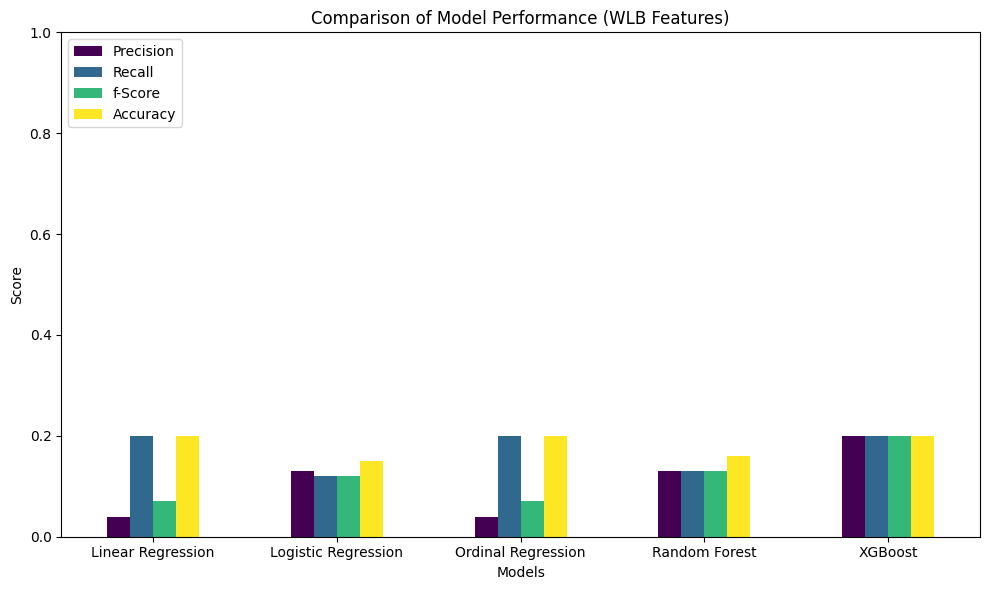

In [ ]:
# Used df_metrics and removed 'Average' row if present
df_plot = df_metrics[df_metrics["Models"] != "Average"].copy()

# cleaned up model names for display
df_plot["Models"] = df_plot["Models"].str.replace(" \(Full\)", "", regex=True)
df_plot.set_index("Models", inplace=True)

# Plot bar chart of all metrics
df_plot[["Precision", "Recall", "f-Score", "Accuracy"]].plot(
    kind='bar', figsize=(10, 6), colormap='viridis'
)
plt.title("Comparison of Model Performance (WLB Features)")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Ran a logistic regression model with the same WLB features to test their statistical significance.

In [ ]:
import statsmodels.api as sm

wlb_features = [
    'Work_Hours_Per_Week', 'Projects_Handled', 'Overtime_Hours',
    'Sick_Days', 'Remote_Work_Frequency', 'Employee_Satisfaction_Score'
]

# Created feature and target datasets
X = df_encoded[wlb_features]
y = df_encoded['Performance_Score']

#Added a constant (intercept term)
X_sm = sm.add_constant(X)

#Fited the model using MNLogit (Multinomial Logistic Regression)
model = sm.MNLogit(y, X_sm)
result = model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 1.609310
         Iterations 3
                          MNLogit Regression Results                          
Dep. Variable:      Performance_Score   No. Observations:               100000
Model:                        MNLogit   Df Residuals:                    99972
Method:                           MLE   Df Model:                           24
Date:                Mon, 14 Apr 2025   Pseudo R-squ.:               7.563e-05
Time:                        18:07:09   Log-Likelihood:            -1.6093e+05
converged:                       True   LL-Null:                   -1.6094e+05
Covariance Type:            nonrobust   LLR p-value:                    0.4420
        Performance_Score=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0484      0.066     -0.736      0.462   